In [23]:
import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
import util

def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id, window_size):
    N = len(tokens)
    X, Y = [], []

    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)

    return X, Y


doc = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."
tokens = nltk.word_tokenize(doc)
word_to_id, id_to_word = mapping(tokens)
X, Y = generate_training_data(tokens, word_to_id, 3)
vocab_size = len(id_to_word)
m = Y.shape[1]
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

In [24]:

def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    return W

def initialize_parameters(vocab_size, emb_size):
    """
    initialize all the trianing parameters
    """
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

In [25]:
def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    
    assert(softmax_out.shape == Z.shape)

    return softmax_out

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    
    return softmax_out, caches

In [26]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
    return cost

In [27]:
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    WRD_EMB = parameters['WRD_EMB']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    WRD_EMB[inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']

In [28]:
def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=True, plot_cost=True):
    """
    X: Input word indices. shape: (1, m)
    Y: One-hot encoding of output word indices. shape: (vocab_size, m)
    vocab_size: vocabulary size of your corpus or training data
    emb_size: word embedding size. How many dimensions to represent each vocabulary
    learning_rate: alaph in the weight update formula
    epochs: how many epochs to train the model
    batch_size: size of mini batch
    parameters: pre-trained or pre-initialized parameters
    print_cost: whether or not to print costs during the training process
    """
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

Cost after epoch 0: 2.756780275654817
Cost after epoch 10: 2.7565498961762365
Cost after epoch 20: 2.7563090534732457
Cost after epoch 30: 2.756042579770476
Cost after epoch 40: 2.7557351206886502
Cost after epoch 50: 2.7553702395984505
Cost after epoch 60: 2.754938642613247
Cost after epoch 70: 2.7544166052928163
Cost after epoch 80: 2.753782215006314
Cost after epoch 90: 2.753011516270184
Cost after epoch 100: 2.752077157331174
Cost after epoch 110: 2.7509699636993
Cost after epoch 120: 2.7496436067823486
Cost after epoch 130: 2.7480573029661457
Cost after epoch 140: 2.7461668051074164
Cost after epoch 150: 2.7439217682316
Cost after epoch 160: 2.741316883248447
Cost after epoch 170: 2.738261396793704
Cost after epoch 180: 2.734683784820115
Cost after epoch 190: 2.7305110984664336
Cost after epoch 200: 2.72566484121607
Cost after epoch 210: 2.720170106454372
Cost after epoch 220: 2.7138798468130556
Cost after epoch 230: 2.7067057203788965
Cost after epoch 240: 2.698575588832026
Cost 

Cost after epoch 2070: 2.102062247798388
Cost after epoch 2080: 2.1019197375770577
Cost after epoch 2090: 2.101789637688122
Cost after epoch 2100: 2.1016720900780146
Cost after epoch 2110: 2.1015690460743093
Cost after epoch 2120: 2.1014784984860353
Cost after epoch 2130: 2.101400295673946
Cost after epoch 2140: 2.1013344957387243
Cost after epoch 2150: 2.1012811378906755
Cost after epoch 2160: 2.1012409199452806
Cost after epoch 2170: 2.101212771158516
Cost after epoch 2180: 2.1011965744479095
Cost after epoch 2190: 2.1011922950020616
Cost after epoch 2200: 2.1011998802030822
Cost after epoch 2210: 2.10121885623408
Cost after epoch 2220: 2.1012490538641795
Cost after epoch 2230: 2.101290394582946
Cost after epoch 2240: 2.1013427619126723
Cost after epoch 2250: 2.101406022939216
Cost after epoch 2260: 2.1014786491477153
Cost after epoch 2270: 2.10156130527298
Cost after epoch 2280: 2.1016539522676165
Cost after epoch 2290: 2.1017564042074492
Cost after epoch 2300: 2.1018684605352096
Co

Cost after epoch 4110: 2.126861853090333
Cost after epoch 4120: 2.1270137914075864
Cost after epoch 4130: 2.127166429322768
Cost after epoch 4140: 2.1273197482175146
Cost after epoch 4150: 2.1274737292187367
Cost after epoch 4160: 2.127625571697219
Cost after epoch 4170: 2.1277777057103044
Cost after epoch 4180: 2.127930420504497
Cost after epoch 4190: 2.128083697309337
Cost after epoch 4200: 2.128237517144347
Cost after epoch 4210: 2.128389085085097
Cost after epoch 4220: 2.1285408305228097
Cost after epoch 4230: 2.128693042328113
Cost after epoch 4240: 2.1288457017991447
Cost after epoch 4250: 2.128998790063454
Cost after epoch 4260: 2.1291495282635906
Cost after epoch 4270: 2.1293003361037988
Cost after epoch 4280: 2.1294515011284227
Cost after epoch 4290: 2.1296030048873806
Cost after epoch 4300: 2.1297548287948023
Cost after epoch 4310: 2.129904219688265
Cost after epoch 4320: 2.130053579124148
Cost after epoch 4330: 2.1302031924133695
Cost after epoch 4340: 2.1303530415084593
Cos

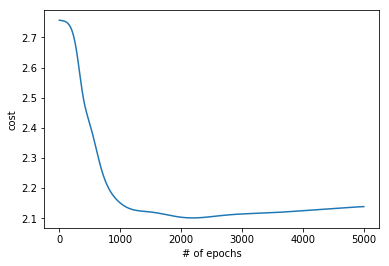

In [29]:
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 5000, batch_size=128, parameters=None, print_cost=True)

In [31]:
X_test = np.arange(vocab_size)
X_test = np.expand_dims(X_test, axis=0)
softmax_test, _ = forward_propagation(X_test, paras)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]

In [32]:
for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    print("{}'s neighbor words: {}".format(input_word, output_words))

loser's neighbor words: ['.', 'a', 'game', "'s"]
beating's neighbor words: ['market', 'stock', 'the', 'investing']
investing's neighbor words: ['the', 'of', ',', 'beating']
,'s neighbor words: ['stock', 'the', 'beating', 'costs']
stock's neighbor words: ['a', 'is', ',', 'market']
of's neighbor words: ['the', 'costs', 'beating', 'of']
.'s neighbor words: ['loser', "'s", 'game', 'stock']
market's neighbor words: ['loser', 'stock', 'is', 'beating']
game's neighbor words: ['.', 'a', 'game', "'s"]
After's neighbor words: ['of', 'the', 'deduction', 'costs']
deduction's neighbor words: ['costs', 'After', 'the', 'of']
the's neighbor words: ['is', 'market', 'the', 'stock']
is's neighbor words: ['loser', "'s", 'market', 'a']
's's neighbor words: ['.', 'a', 'game', "'s"]
a's neighbor words: ['loser', "'s", 'game', 'stock']
costs's neighbor words: [',', 'of', 'the', 'deduction']


In [37]:
print(X_test)

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]]
